# PIPS 0.3.0 tests

In [1]:
import PIPS
import matplotlib.pyplot as plt
import time
import numpy as np

## data prep

In [2]:
data = PIPS.data_readin_LPP('sample_data/005.dat',filter='V')
x,y,yerr=data
star = PIPS.photdata(data)

# tests

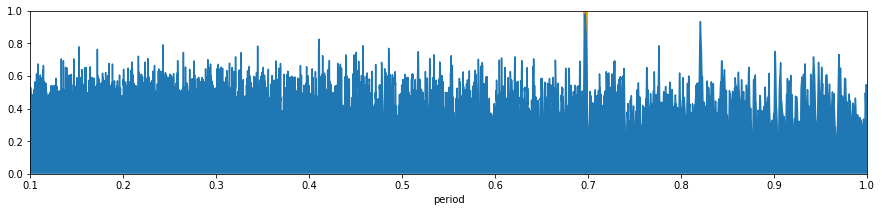

[0.69683711]


In [3]:
# periodogram test
periods,power = star.periodogram(p_min=0.1,p_max=1,multiprocessing=False)

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

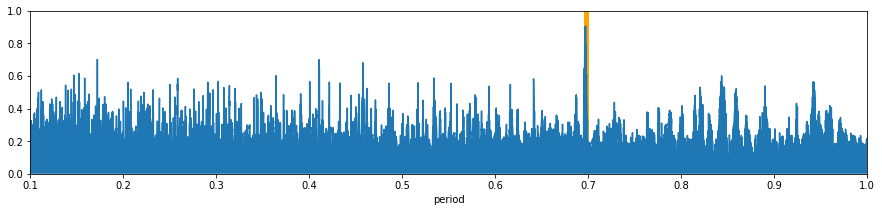

[0.69731154]
32.303 sec.


In [3]:
# periodogram test w/ Gaussian
t0 = time.time()
periods,power = star.periodogram(p_min=0.1,p_max=1,method='custom',model='Gaussian',multiprocessing=False,Nterms=1)
tf = time.time()

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])
print(f'{tf-t0:.3f} sec.')

In [3]:
# periodogram test w/ custom function
def SG(x,period,params,p):
    mod = np.remainder(x,period)
    return params[0] + params[1]*np.exp(-((mod-params[2])**2/(2*params[3]**2))**p)

def SG_p0(x,y,yerr,period,**kwargs):
    return [np.mean(y),1,period/2,period/4]

t0 = time.time()
periods,power = star.periodogram(
                    p_min=0.1,
                    p_max=1,
                    method='custom',
                    model=SG,
                    p0_func=SG_p0,
                    multiprocessing=False,
                    p=1)
tf = time.time()
print(f'{tf-t0:.3f} sec.')

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(0, 1)

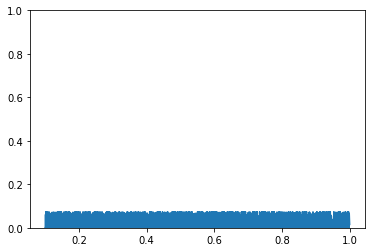

In [5]:
plt.plot(periods,power)
plt.ylim(0,1)

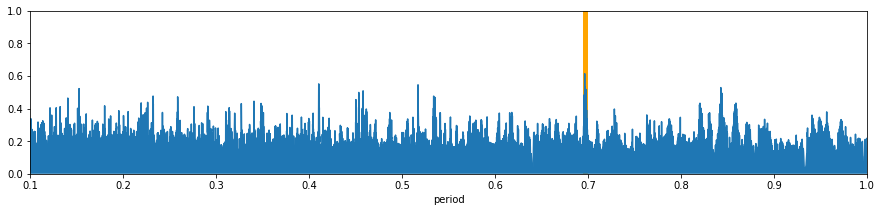

[0.69636268]


In [7]:
# periodogram test w/ Gaussian
periods,power = star.periodogram(p_min=0.1,p_max=1,method='fast',model='Gaussian',Nterms=1,multiprocessing=False)

# plot
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

In [5]:
# period detection test
star.get_period(multiprocessing=False)

(0.6968874975991536, 0.0065881527515392994)

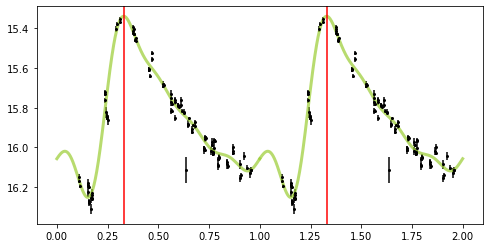

In [6]:
# auto plotting & best-fit curve generation & epoch detection test
star.plot_lc()
x_th,y_th = star.get_bestfit_curve(period=star.period)
epoch_offset = star.get_epoch_offset() # the epoch offset in the unit of [days] (not normalized to phase)

# plot
plt.plot(x_th/star.period,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.plot(x_th/star.period+1,y_th,c='yellowgreen',lw=3,alpha=0.7)
plt.axvline(epoch_offset/star.period,color='red')
plt.axvline(epoch_offset/star.period+1,color='red')

/home/sterlingym/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


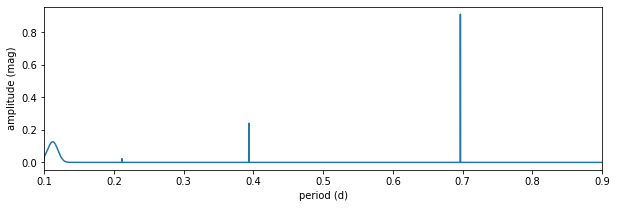

In [7]:
# multi-period detection test
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10,multiprocessing=False)
plt.figure(figsize=(10,3));plt.plot(period,spectrum);plt.xlim(0.1,0.9);plt.xlabel('period (d)');plt.ylabel('amplitude (mag)');plt.show()

# misc (old, to be cleaned)

### Gaussian Mixture

$$ y_i = \sum_j^K p_j \exp{\left(-\frac{\left[(x_i \mod P)-\mu_j\right]^2}{2\sigma_{y,i}^2}\right)}$$

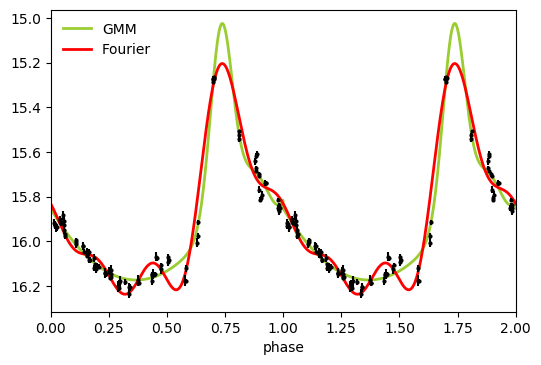

In [8]:
from PIPS.periodogram.models.Gaussian import gaussian, get_bestfit_gaussian
from PIPS.periodogram.models.Fourier import fourier, get_bestfit_Fourier

Nterms = 4
period = star.period
popt_gaussian = get_bestfit_gaussian(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
popt_fourier = get_bestfit_Fourier(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)

x_th = np.linspace(0,period*2,1000)
y_th_gaussian = gaussian(x_th,period,Nterms,np.array(popt_gaussian))
y_th_fourier = fourier(x_th,period,Nterms,np.array(popt_fourier))

plt.figure(dpi=100)
plt.plot(x_th/period,y_th_gaussian,c='yellowgreen',lw=2,zorder=0,label='GMM')
plt.plot(x_th/period,y_th_fourier,c='red',lw=2,zorder=0,label='Fourier')
plt.errorbar(star.x%period/period,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.errorbar(star.x%period/period+1,star.y,star.yerr,ms=2,c='k',zorder=1,fmt='o')
plt.xlabel('phase');plt.xlim(0,2);plt.legend(frameon=False)
plt.gca().invert_yaxis()

In [9]:
Nterms = 3
t0 = time.time()
for _ in range(100):
    popt_fourier = get_bestfit_Fourier(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
print(f'---- {time.time()-t0:.3f} seconds ----')

---- 0.123 seconds ----


In [5]:
t0 = time.time()
for _ in range(100):
    popt_gaussian = get_bestfit_gaussian(star.x,star.y,star.yerr,period,Nterms,return_yfit=False,return_params=True)
print(f'---- {time.time()-t0:.3f} seconds ----')

---- 82.149 seconds ----


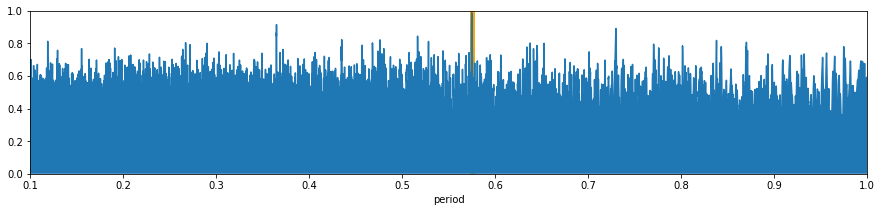

[0.57490775]


In [14]:
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

---- 132.924 seconds ----


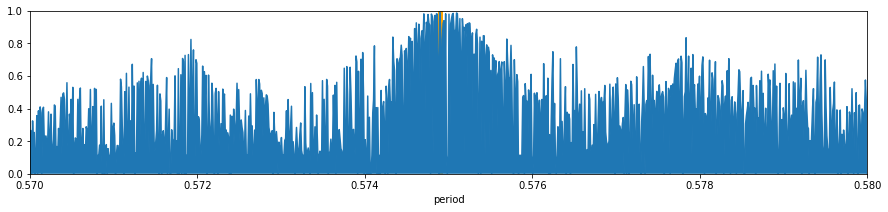

[0.57489489]


In [8]:
# Gaussian periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.57,p_max=0.58,Nterms=3,method='custom',model='Gaussian',N=1000)
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

---- 70.937 seconds ----


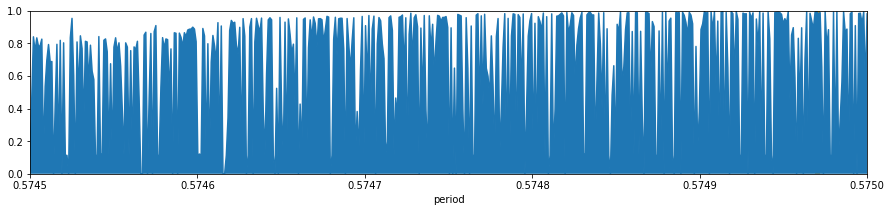

[0.57496994]


In [10]:
# Gaussian periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.5745,p_max=0.575,Nterms=3,method='custom',model='Gaussian',N=500)
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

---- 0.826 seconds ----


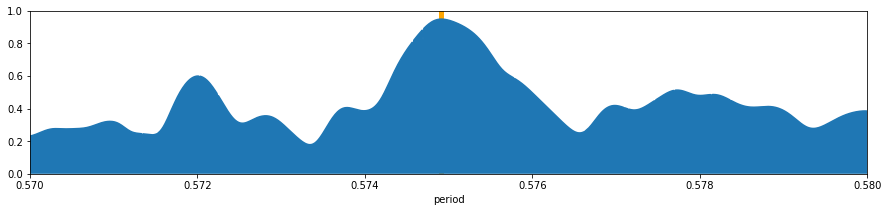

[0.57491491]


In [9]:
# Fourier periodogram near the peak
t0 = time.time()
periods,power = star.periodogram(p_min=0.57,p_max=0.58,Nterms=3,method='custom',model='Fourier',N=1000)
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(periods,power);plt.fill_between(periods,0,power);plt.xlabel('period');plt.xlim(periods.min(),periods.max());plt.ylim(0,1);plt.axvline(periods[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(periods[power==power.max()])

## main period detection

In [15]:
period,err = star.get_period(Nterms=5,N0=5,peaks_to_test=5,debug=True,multiprocessing=False)

0.000s --- starting the process...
0.000s --- preparing data...
0.000s --- getting a periodogram...
0.464s --- detecting top 5 peaks...
0.464s --- preparing for finer sampling near peaks...
0.464s --- performing finer sampling near peaks...
0.616s --- period candidate:  0.5748945463665658
0.618s --- detecting aliasing...
0.619s --- alias factor:  1
0.619s --- period candidate:  0.5748945463665658
0.619s --- estimating the uncertainty...
0.620s --- period candidate:  0.5748945463665658
0.620s --- period fitted*:  0.5748945428824601
0.620s --- period error:  inf
0.621s --- refining samples...
0.621s --- refining search width = 6.588e-04
0.653s --- period candidate:  0.5748866247400108
0.653s --- period fitted*:  0.5748945428824601
0.654s --- period error:  7.499076555128298e-06
0.654s --- * validating period error...
0.654s --- * fitted period - peak period = 7.92e-06
0.654s --- * expected deviation size = 7.50e-06
0.654s --- * period error validated
0.654s --- period = 0.5748866 +- 0.00

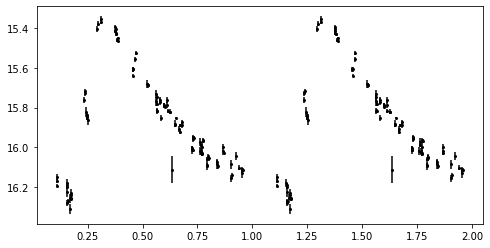

In [4]:
star.plot_lc()

## multi-period detection & amplitude spectrum

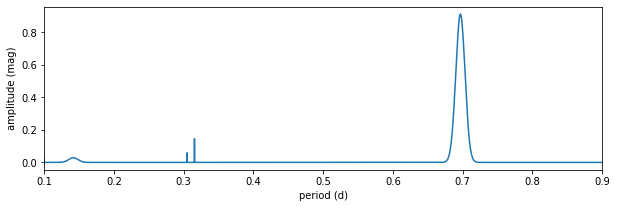

In [5]:
period,spectrum = star.amplitude_spectrum(p_min=0.1,p_max=0.9,N=10)
plt.figure(figsize=(10,3));plt.plot(period,spectrum);plt.xlim(0.1,0.9);plt.xlabel('period (d)');plt.ylabel('amplitude (mag)');plt.show()

## misc: periodogram

---- 0.637 seconds ----


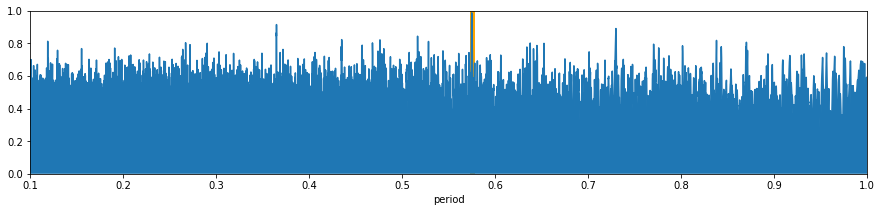

[0.57490775]


In [7]:
# periodogram -- fast method
t0 = time.time()
period,power = star.periodogram(p_min=0.1,p_max=1,Nterms=5,method='fast')
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(period,power);plt.fill_between(period,0,power);plt.xlabel('period');plt.xlim(period.min(),period.max());plt.ylim(0,1);plt.axvline(period[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(period[power==power.max()])

---- 9.419 seconds ----


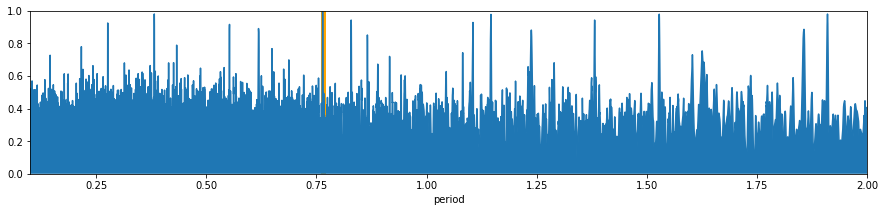

[0.7640485]


In [7]:
# slower but customizable method (users can add custom models)

# Note: this method sometimes raises warnings
#       when cov-matrix cannot be estimated.
#       This does not affect our results, so I'm ignoring warnings.
from warnings import filterwarnings
filterwarnings(action='ignore')

t0 = time.time()
period,power = star.periodogram(p_min=0.1,p_max=2,Nterms=5,method='custom')
print(f'---- {time.time()-t0:.3f} seconds ----')
plt.figure(figsize=(15,3));plt.plot(period,power);plt.fill_between(period,0,power);plt.xlabel('period');plt.xlim(period.min(),period.max());plt.ylim(0,1);plt.axvline(period[power==power.max()],c='orange',lw=5,zorder=0);plt.show()
print(period[power==power.max()])

# Linear Algebra Method
Y.Murakami, 1/3/2020

### data
$i$: data point ($x_i, y_i, \sigma_{y,i}$)<br>
$j$: Fourier term index

$$ 
x_{i} = \left(\begin{matrix} x_0\\ x_1\\ \vdots\\ x_n \end{matrix}\right),\ 
y_{i} = \left(\begin{matrix} y_0\\ y_1\\ \vdots\\ y_n \end{matrix}\right),\ 
\sigma_{y,i} = \left(\begin{matrix} \sigma_{y,0}\\ \sigma_{y,1}\\ \vdots\\ \sigma_{y,n} \end{matrix}\right),\
w_{i} = \frac{1}{\Sigma (1/\sigma_{y,i}^2)}\left(\begin{matrix} 1/\sigma_{y,0}^2\\ 1/\sigma_{y,1}^2\\ \vdots\\ 1/\sigma_{y,n}^2 \end{matrix}\right),\
$$

### Weigted mean, floating mean correction (offset)
$$\langle y \rangle = w_i y_i,\ Y_i = y_i - \langle y \rangle$$


### Model Matrix
$$
X_{ij}(\omega) = \left(\begin{matrix}
1 & \sin(\omega x_0) & \sin(2\omega x_0) & \cdots & \sin(K\omega x_0) & \cos(\omega x_0) & \cos(2\omega x_0) & \cdots & \cos(K\omega x_0) \\
1 & \sin(\omega x_1) & \sin(2\omega x_1) & \cdots & \sin(K\omega x_1) & \cos(\omega x_1) & \cos(2\omega x_1) & \cdots & \cos(K\omega x_1) \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots & \vdots \\
1 & \sin(\omega x_n) & \sin(2\omega x_n) & \cdots & \sin(K\omega x_n) & \cos(\omega x_n) & \cos(2\omega x_n) & \cdots & \cos(K\omega x_n) \\
\end{matrix}\right)
$$

### Optimization
$$ X_{ij}\theta_{j} = Y_i \quad \Rightarrow \quad X_{ji}X_{ij}\theta_j = X_{ji}Y_i \quad\Rightarrow\quad \theta_j = (X_{ji}X_{ij})^{-1}X_{ji}Y_i$$

### Best-fit values
$$ Y_{i,\text{fit}} = X_{ij}\theta_j $$

### $\chi^2$ and power calculation
$$ 
\chi^2_i = \frac{(y_i - y_{i,fit})^2}{\sigma_{y,i}^2}, \quad
\chi^2_\text{ref} = \frac{(y_i - \langle y \rangle)^2}{\sigma_{y,i}^2} = \frac{Y_i^2}{\sigma_{y,i}^2}
$$

\begin{align*}
\text{Power}(\omega)_i &= \chi^2_\text{ref} - \chi^2_i \\
&= \frac{y_i^2 - 2y_i\langle y \rangle + \langle y \rangle^2 - y_i^2 + 2y_iy_{i,fit} - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \langle y \rangle^2 - y_{i,fit}^2}{\sigma_{y,i}^2} \\
&= \frac{2y_i\left(y_{i,fit} - \langle y \rangle\right) + \left(\langle y \rangle + y_{i,fit}\right)\left(\langle y \rangle - y_{i,fit}\right)}{\sigma_{y,i}^2} \\
&= \frac{\left(2y_i - \langle y \rangle - y_{i,fit} \right) \left(y_{i,fit} - \langle y \rangle\right) }{\sigma_{y,i}^2} \\
&= \frac{\left(Y_i + \Delta Y_\text{data-fit}\right)Y_{i,fit}}{\sigma_{y,i}^2}
\end{align*}